In [34]:
import os
import random
import string

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFT5ForConditionalGeneration, pipeline

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.bleu_score import sentence_bleu

from PIL import Image
import torch
import torch.optim as optim
from torchvision import transforms, models

In [35]:
# Global settings
pd.set_option("display.max_colwidth", 200)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Disable warnings
random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [36]:
# 1. NEURAL MACHINE TRANSLATION WITH SEQ2SEQ RNN
# Dataset:  https://www.manythings.org/anki/ukr-eng.zip
text_file = "input/ukr.txt"
n_samples = 10000
text_pairs = []
with open(text_file, mode = "r", encoding = "utf-8") as fin:
    for line in fin:
        eng, ukr = line.split("\t")[:2]
        text_pairs.append([ukr, eng])
data = pd.DataFrame(text_pairs[:n_samples], columns = ["ukr", "eng"])
display(data.head())

ukr   eng
0     Йди.   Go.
1   Вітаю!   Hi.
2  Привіт.   Hi.
3  Привіт!   Hi.
4  Біжіть!  Run!

In [37]:
# Clean texts
def clean_text(text):
    lowercase = text.lower()
    translator = str.maketrans("", "", string.punctuation)
    no_punctuation = lowercase.translate(translator)
    return no_punctuation


data_before = data.copy()
data["ukr"] = data["ukr"].apply(clean_text)
data["eng"] = data["eng"].apply(clean_text)
display(data_before.head(6))
display(data.head(6))

ukr   eng
0      Йди.   Go.
1    Вітаю!   Hi.
2   Привіт.   Hi.
3   Привіт!   Hi.
4   Біжіть!  Run!
5  Тікайте!  Run!

ukr  eng
0      йди   go
1    вітаю   hi
2   привіт   hi
3   привіт   hi
4   біжіть  run
5  тікайте  run

<Figure size 1000x500 with 0 Axes>

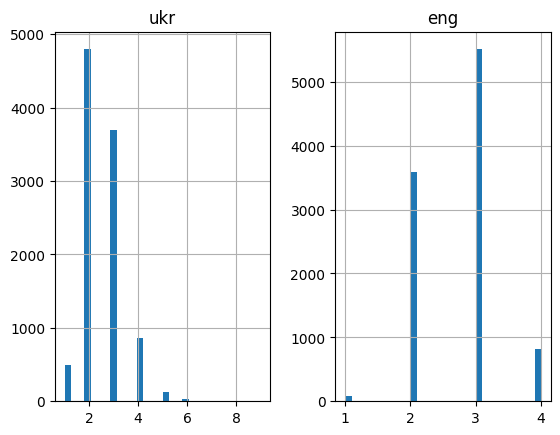

[ukr] max length:       9
[eng] max length:       4



In [38]:
# Determine max length of texts
lengths_ukr = data["ukr"].apply(lambda x: len(x.split()))
lengths_eng = data["eng"].apply(lambda x: len(x.split()))

length_df = pd.DataFrame({"ukr": lengths_ukr, "eng": lengths_eng})
plt.figure(figsize = (10, 5))
length_df.hist(bins = 30)
plt.show()

max_len_ukr = int(lengths_ukr.max())
max_len_eng = int(lengths_eng.max())
print(f"[ukr] max length:       {max_len_ukr}")
print(f"[eng] max length:       {max_len_eng}\n")

In [39]:
# Tokenize texts
def tokenize(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    return tokenizer, vocab_size


tokenizer_ukr, vocab_size_ukr = tokenize(data["ukr"])
tokenizer_eng, vocab_size_eng = tokenize(data["eng"])
print(f"[ukr] vocabulary size:  {vocab_size_ukr}")
print(f"[eng] vocabulary size:  {vocab_size_eng}\n")

[ukr] vocabulary size:  4825
[eng] vocabulary size:  1929



In [40]:
# Split dataset into training set and test set
def str2seq(texts, tokenizer, max_len):
    seqs = tokenizer.texts_to_sequences(texts)
    seqs = pad_sequences(seqs, maxlen = max_len, padding = "post")
    return seqs.astype("int16")


X = data["ukr"].tolist()
y = data["eng"].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

X_train_seq = str2seq(X_train, tokenizer_ukr, max_len_ukr)
y_train_seq = str2seq(y_train, tokenizer_eng, max_len_eng)

X_test_seq = str2seq(X_test, tokenizer_ukr, max_len_ukr)
y_test_seq = str2seq(y_test, tokenizer_eng, max_len_eng)

print("[ukr] text to padded integer sequence:\n"
      f"  (raw) -> {X_test[0]}\n"
      f"  (seq) -> {X_test_seq[0]}\n")

print("[eng] text to padded integer sequence:\n"
      f"  (raw) -> {y_test[0]}\n"
      f"  (seq) -> {y_test_seq[0]}\n")

[ukr] text to padded integer sequence:
  (raw) -> том задоволений
  (seq) -> [  2 188   0   0   0   0   0   0   0]

[eng] text to padded integer sequence:
  (raw) -> is tom happy
  (seq) -> [ 6  2 95  0]



In [41]:
# Create and compile RNN model
units = 256
model = Sequential(
    [
        Embedding(
            input_dim = vocab_size_ukr,
            input_length = max_len_ukr,
            output_dim = units,
            mask_zero = True
        ),
        LSTM(units = units, return_sequences = False),
        RepeatVector(max_len_eng),
        LSTM(units = units, return_sequences = True),
        Dense(units = vocab_size_eng, activation = "softmax")
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 9, 256)            1235200   
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 4, 256)            0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 4, 256)            525312    
                                                                 
 dense_1 (Dense)             (None, 4, 1929)           495753    
                                                                 
Total params: 2781577 (10.61 MB)
Trainable params: 2781577 (10.61 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [42]:
# Compile and fit RNN
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)
model.fit(X_train_seq, y_train_seq, epochs = 100, batch_size = 256, validation_split = 0.1)

Epoch 1/100
29/29 [==============================] - 8s 129ms/step - loss: 6.4456 - accuracy: 0.3137 - val_loss: 4.8774 - val_accuracy: 0.3253
Epoch 2/100
29/29 [==============================] - 2s 80ms/step - loss: 4.5133 - accuracy: 0.3425 - val_loss: 4.3510 - val_accuracy: 0.3719
Epoch 3/100
29/29 [==============================] - 2s 80ms/step - loss: 4.0578 - accuracy: 0.3739 - val_loss: 4.0494 - val_accuracy: 0.3716
Epoch 4/100
29/29 [==============================] - 2s 80ms/step - loss: 3.8609 - accuracy: 0.3738 - val_loss: 3.9336 - val_accuracy: 0.3741
Epoch 5/100
29/29 [==============================] - 2s 85ms/step - loss: 3.7513 - accuracy: 0.3812 - val_loss: 3.8641 - val_accuracy: 0.3806
Epoch 6/100
29/29 [==============================] - 2s 86ms/step - loss: 3.6678 - accuracy: 0.3869 - val_loss: 3.8200 - val_accuracy: 0.3856
Epoch 7/100
29/29 [==============================] - 3s 87ms/step - loss: 3.5972 - accuracy: 0.3907 - val_loss: 3.7847 - val_accuracy: 0.3853
Epoch

In [43]:
# Translate ukrainian texts to english with RNN
probs = model.predict(X_test_seq)
y_pred_seq = np.argmax(probs, axis = -1)
y_pred = tokenizer_eng.sequences_to_texts(y_pred_seq)
trans_df = pd.DataFrame({"ukr": X_test, "eng": y_test, "predicted": y_pred})
display(trans_df.head(15))

63/63 [==============================] - 2s 11ms/step


ukr            eng      predicted
0         том задоволений   is tom happy        toms is
1       том робив зарядку  tom exercised  tom exercised
2   мені до вподоби інжир    i love figs     im not now
3        вони помиляються   theyre wrong     theyre bad
4      том ніби в порядку   tom seems ok      tom is ok
5             ти кумедний    youre funny    youre awful
6           це дуже легко    its so easy    its so easy
7       ви несправедливий   youre unfair    are is nice
8                 ти злий     youre evil  are you angry
9            мене не було     i was away      i was out
10         я вам розповім   ill tell you   ill tell you
11             ти смілива    youre brave  are you brave
12              насправді      seriously         fix it
13          вона має вино   she has wine   she has wine
14             ми розумні     were smart     were tough

In [49]:
# Estimate an accuracy of translation
matches = trans_df["eng"] == trans_df["predicted"]
n_matches = matches.sum()
print(f"Exact translations: {n_matches}/{len(trans_df)}")

bleu = []
meteor = []
for index, row in trans_df.iterrows():
    reference = row["eng"]
    candidate = row["predicted"]

    bleu_score = sentence_bleu([reference], candidate)
    meteor_score = single_meteor_score(reference.split(), candidate.split())

    bleu.append(bleu_score)
    meteor.append(meteor_score)

bleu = np.mean(bleu)
meteor = np.mean(meteor)
print(f"BLEU score:     {bleu:.3f}")
print(f"METEOR score:   {meteor:.3f}")

Exact translations: 331/2000
BLEU score:     0.383
METEOR score:   0.381


In [50]:
# 2. HUGGING FACE TRANSFORMERS
summarizer_dir = "input/uk-summarizer"
tokenizer = AutoTokenizer.from_pretrained(summarizer_dir)
model = TFT5ForConditionalGeneration.from_pretrained(summarizer_dir)
summarizer = pipeline(
    task = "summarization",
    model = model,
    tokenizer = tokenizer,
    device = 0,
    max_length = 128,
    num_beams = 4,
    no_repeat_ngram_size = 2,
    clean_up_tokenization_spaces = True
)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [51]:
# Summarize a text
text = """
Папоротеподі́бні — група судинних рослин, що належить до групи Moniliformopses. Здебільшого це багаторічні (рідше однорічні) трави, іноді дерева з самостійним гаплоїдним і диплоїдним поколіннями з величезним переважанням у циклі розвитку спорофита.

Папороть з'явилися на Землі близько 400 мільйонів років тому в середньому девоні (палеозої). Вони були справжніми гігантами та формували рослинний покрив планети. Папороть утворювали цілі ліси. Зараз на Землі залишилося дуже мало деревоподібних папоротей. Сучасні папороті набагато менші за ті, що існували в ранні геологічні періоди.

Беруть участь у формуванні травянистого покриву. З XIX століття папороті популярні як кімнатні рослини. Представники папоротеподі́бних: орляк, щитник чоловічий, страусове перо звичайне, сальвінія плаваюча, диксонія, марсилія, маратія, платицеріум, азола, адіант венерин волос. 
"""
summary = summarizer(text)
print(summary[0]["summary_text"])

Група судинних рослин, відомих як папоротеподі́бні, з'явилася на Землі близько 400 мільйонів років тому.


In [52]:
# 3. NEURAL STYLE TRANSFER
# Content jpg:  https://next3-assets.s3.amazonaws.com/journeys/102/description_backgrounds-1519398938-Skyscrapers_Intorblue.jpg
# Style jpg:    https://images.wallpaperscraft.ru/image/single/kraska_zhidkost_razvody_208736_3024x4032.jpg
def load_image(image_path, img_size):
    loader = transforms.Compose([
        transforms.Resize(size = (img_size, img_size)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image


img_size = 400
content = load_image("input/city.jpg", img_size)
style = load_image("input/paints.jpg", img_size)

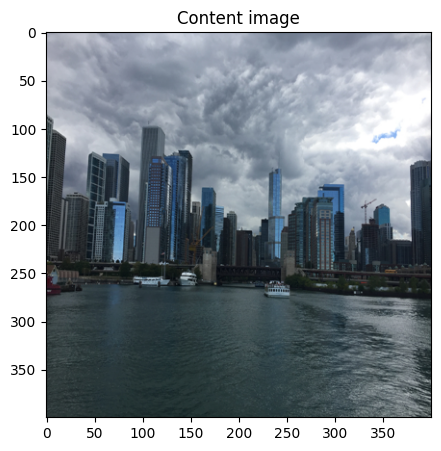

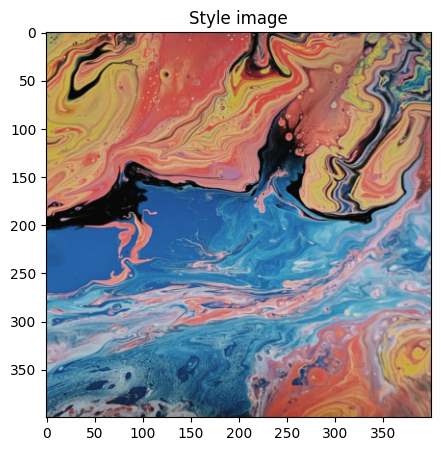

In [53]:
# Show images
def show_image(tensor, title = None):
    # Un-normalize and convert back to PIL image
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = image.mul(255).byte()
    image = image.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize = (5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.show()


show_image(content, "Content image")
show_image(style, "Style image")

In [54]:
# Load VGG19 and freeze its parameters
vgg = models.vgg19(pretrained = True).features
for param in vgg.parameters():
    param.requires_grad_(False)

# Force a model to use CPU
device = torch.device("cpu")
print(vgg.to(device))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [55]:
# Get features of images
def get_features(image, model):
    layers = {"0": "conv1_1",
              "5": "conv2_1",
              "10": "conv3_1",
              "19": "conv4_1",
              "21": "conv4_2",  # Content representation
              "28": "conv5_1"}
    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)  # Get the features for each layer
        if name in layers:
            features[layers[name]] = x
    return features


# Get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [56]:
# Get gram matrices or each layer of style features and create transfer img
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
transfer = content.clone().requires_grad_(True).to(device)

# Define weights for each style layer and other constants
style_weights = {  # No conv4_2
    "conv1_1": 1,
    "conv2_1": 0.75,
    "conv3_1": 0.2,
    "conv4_1": 0.2,
    "conv5_1": 0.2
}
content_weight = 1
style_weight = 1000

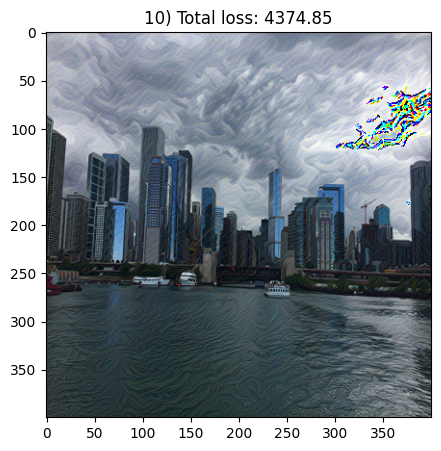

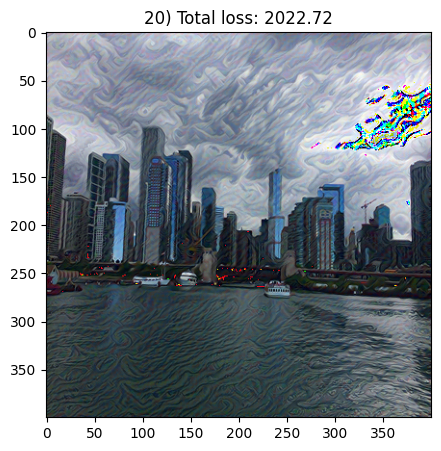

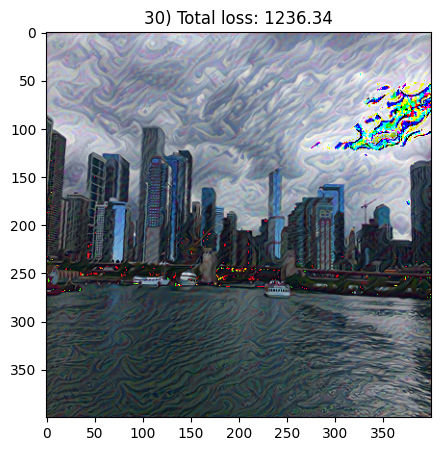

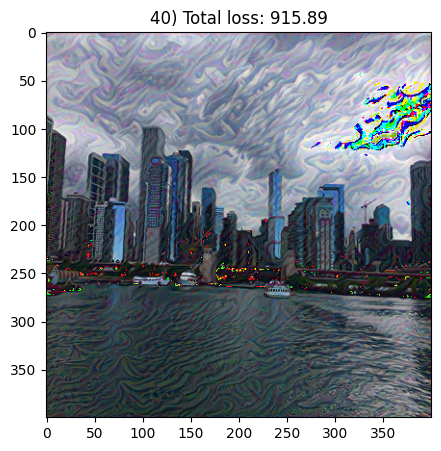

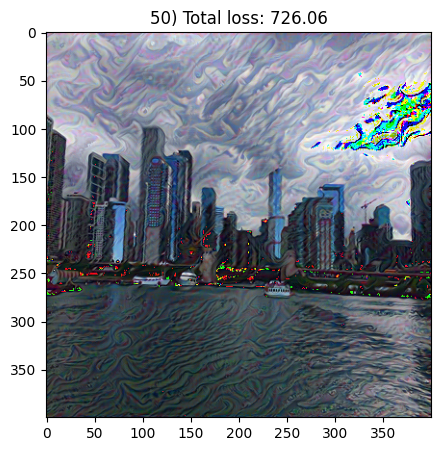

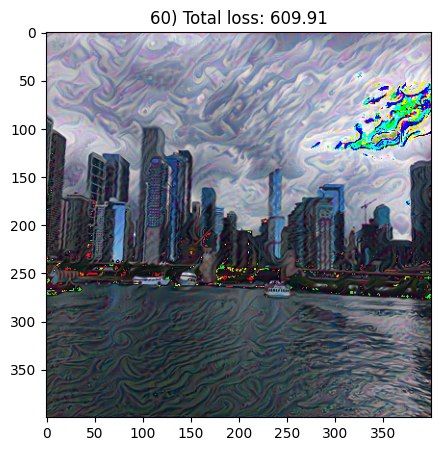

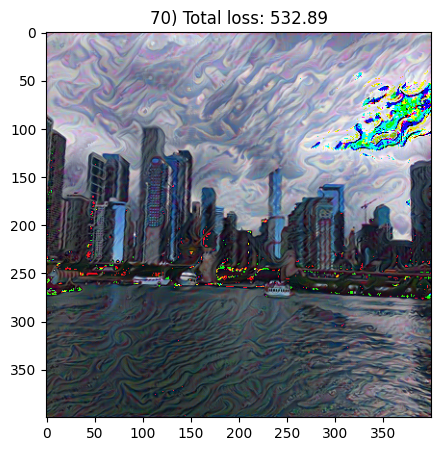

In [57]:
# Do NST
iterations = 70
show_every = 10  # Show img after every N iteration
optimizer = optim.Adam([transfer], lr = 0.003)  # Learning rate (lr) = 0.003

for i in range(1, iterations + 1):
    transfer_features = get_features(transfer, vgg)

    # Calculate MSE for content img
    content_loss = torch.mean((transfer_features["conv4_2"] - content_features["conv4_2"]) ** 2)
    style_loss = 0

    # Add to style_loss for each layer's gram matrix loss
    for layer in style_weights:
        transfer_feature = transfer_features[layer]
        _, d, h, w = transfer_feature.shape

        transfer_gram = gram_matrix(transfer_feature)
        style_gram = style_grams[layer]

        # Calculate weighted MSE for one layer
        layer_style_loss = torch.mean((transfer_gram - style_gram) ** 2)
        layer_style_loss *= style_weights[layer]

        style_loss += layer_style_loss / (d * h * w)

    # Calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()  # Zero the gradients to prevent gradient accumulation
    total_loss.backward()  # The gradient of the loss using backpropagation
    optimizer.step()  # Update the weights

    # Show intermediate images
    if i % show_every == 0:
        title = f"{i}) Total loss: {total_loss.item():.2f}"
        show_image(transfer, title)

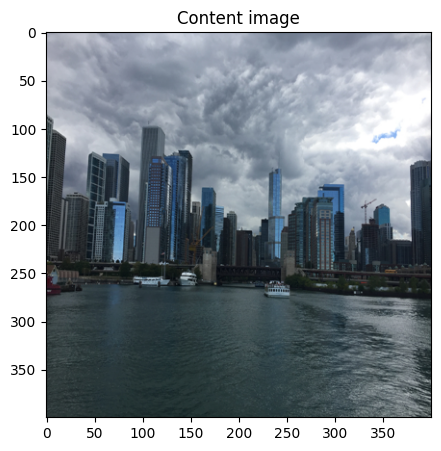

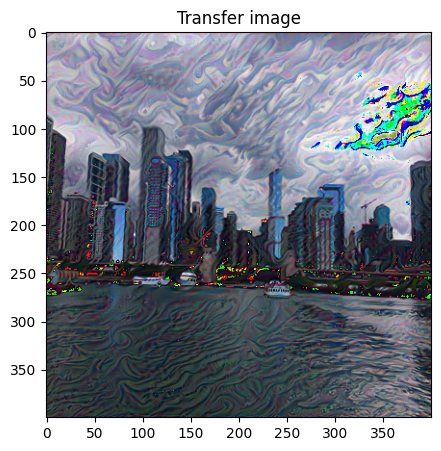

In [59]:
# Display content and final version of transfer image
show_image(content, "Content image")
show_image(transfer, "Transfer image")